# Demo

In [2]:
# Basic libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("viridis")
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'  # affects imshow, heatmap, etc.

from PIL import Image

In [10]:
!pip uninstall -y torchvision
!pip install torchvision --no-cache-dir

Found existing installation: torchvision 0.22.0
Uninstalling torchvision-0.22.0:
  Successfully uninstalled torchvision-0.22.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 189.0 MB/s eta 0:00:00


In [12]:
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embedding import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder
from osgen.base import BaseModel
from osgen.nn import *

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

## Load data

In [ ]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


### Extract patches

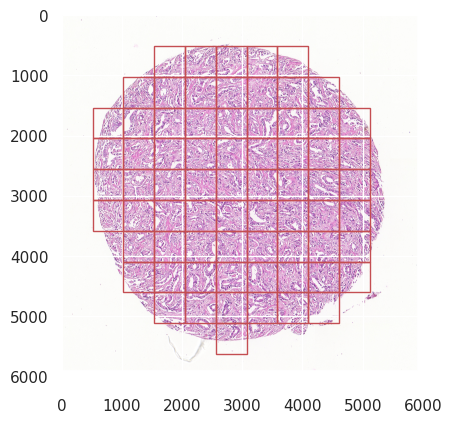

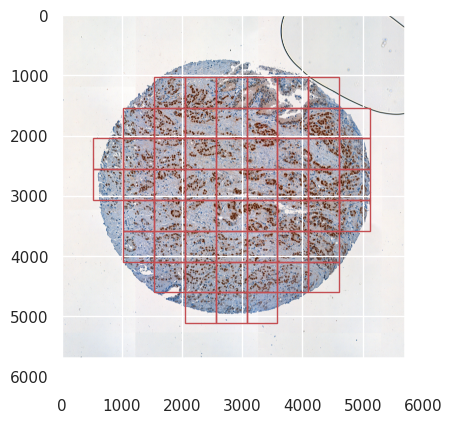

In [ ]:
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[0]))),
)

patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[0])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[0]))),
)

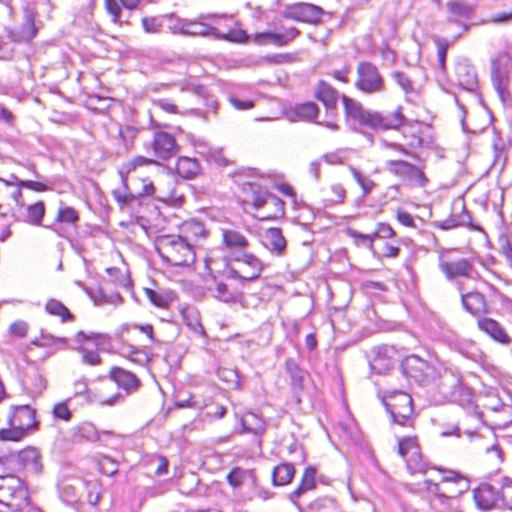

In [ ]:
# Get patch to test
test_patch_src = patches_src[10]
Image.fromarray(test_patch_src)

In [4]:
# Get patch to test
test_patch_dst = patches_dst[10]
Image.fromarray(test_patch_dst)

NameError: name 'patches_dst' is not defined

## Style extractor test

In [5]:
# Convert test patches to tensor
ut = Utilities()

test_patch_src_tensor = ut.convert_numpy_to_tensor(test_patch_src)
test_patch_dst_tensor = ut.convert_numpy_to_tensor(test_patch_dst)

print("test_patch_src_tensor shape: ", test_patch_src_tensor.shape)
print("test_patch_dst_tensor shape: ", test_patch_dst_tensor.shape)

NameError: name 'Utilities' is not defined

In [6]:
extractor = StyleExtractor()
out = extractor(test_patch_dst_tensor)
print("out shape: ", out.shape)

NameError: name 'StyleExtractor' is not defined

## Full VAE test

In [11]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
vae = VanillaVAE(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64]
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    [mu, log_var] = vae.encode(test_patch_src_tensor)

# print("Input shape:", input_tensor.shape)
# print("Reconstructed shape:", reconstructed.shape)
print("Latent mu shape:", mu.shape)
print("Latent log_var shape:", log_var.shape)

# 5. Compute loss (optional)?
# loss_dict = vae.loss_function(reconstructed, input_tensor, mu, log_var, M_N=1.0)
# print("Losses:", loss_dict)

Latent mu shape: torch.Size([1, 64, 128, 128])
Latent log_var shape: torch.Size([1, 64, 128, 128])


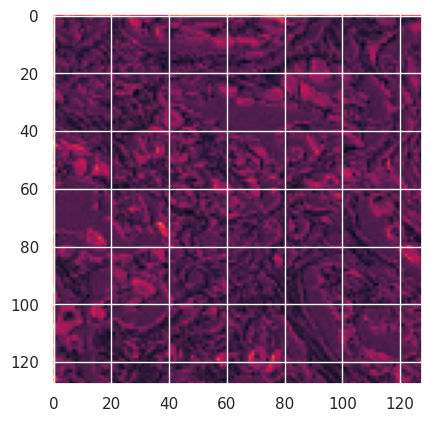

In [12]:
plt.imshow(mu[0][60].cpu().numpy())

## Encoder test

In [13]:
# Define model parameters
in_channels = 3
latent_dim = 512  # you can adjust this
hidden_dims = [32, 64, 128, 256]  # same as your encoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Create dummy test input (or use your real tensor)
# test_patch_src_tensor = torch.randn(1, 3, 512, 512).to(device)

# Convert input tensor to device
test_patch_src_tensor = test_patch_src_tensor.to('cuda')

# 3. Instantiate the model
encoder = VanillaEncoder(
    in_channels=3,
    latent_dim=64,  # You can choose a different latent dimension
    hidden_dims=[32, 64, 128],  # same as your encoder,
    learned=True
).to(device)

vae.eval()

# 4. Forward pass
with torch.no_grad():
    encoded = encoder(test_patch_src_tensor)
print("Encoded shape:", encoded.shape)

Encoded shape: torch.Size([1, 64, 64, 64])


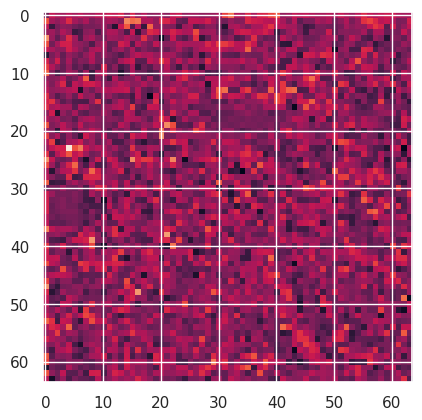

In [14]:
plt.imshow(encoded[0][1].cpu().numpy())

## U-Net model

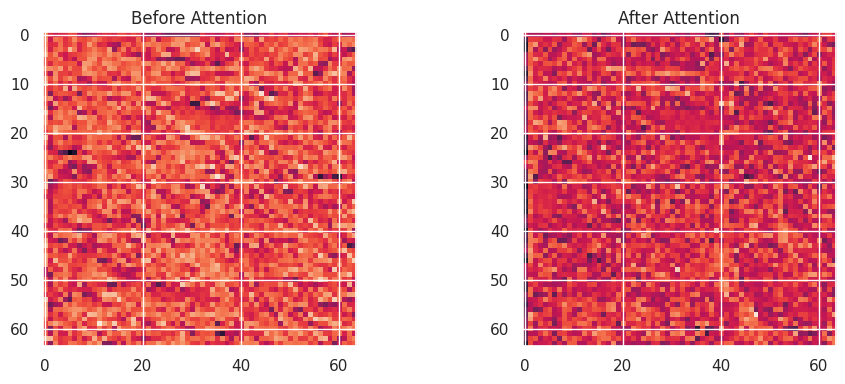

In [15]:
import torch.nn as nn
import matplotlib.pyplot as plt

# Simulate input
x = encoded  # [B, C, H, W]
original = x.clone()

# Flatten for attention
B, C, H, W = x.shape
x_flat = x.view(B, C, H * W).transpose(1, 2)     # [B, 4096, 64]
x_attn = x_flat.transpose(0, 1)                  # [4096, 1, 64]

# Multi-head attention
mha = nn.MultiheadAttention(embed_dim=64, num_heads=4, batch_first=False).cuda()
attn_output, _ = mha(x_attn, x_attn, x_attn)

# Reshape back
attn_output = attn_output.transpose(0, 1)        # [1, 4096, 64]
attn_output = attn_output.transpose(1, 2).view(B, C, H, W)

# Convert tensors to CPU numpy
original_img = original[0, 0].detach().cpu().numpy()  # Channel 0
attn_img = attn_output[0, 0].detach().cpu().numpy()   # Same channel after attention

# Plot before/after
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Before Attention")
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(attn_img)
plt.title("After Attention")
# plt.axis('off')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Original Image')

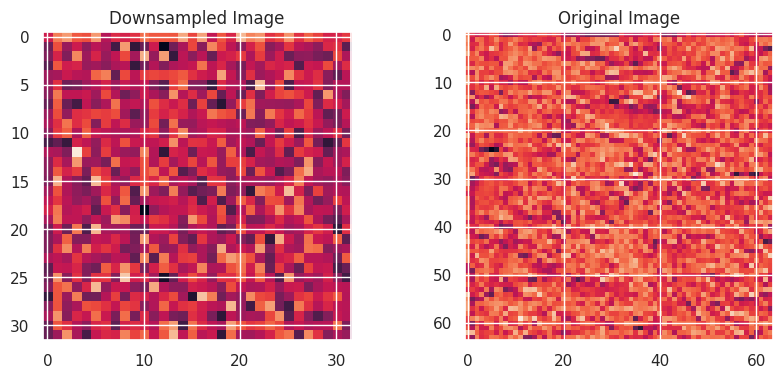

In [16]:
# Instantiate the module
downsample = Downsample(in_channels=64, use_conv=True).to('cuda')

# Create a test input tensor
x = encoded

# Run the forward pass
output = downsample(x)

# Visualize the output image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(output[0][0].cpu().detach().numpy())
plt.title("Downsampled Image")
# Visualize the original image
plt.subplot(1, 2, 2)
plt.imshow(x[0][0].cpu().detach().numpy())
plt.title("Original Image")

In [17]:
downsample.visualize_network(x)

Original shape: torch.Size([1, 64, 64, 64])
Upsampled shape: torch.Size([1, 128, 128, 128])


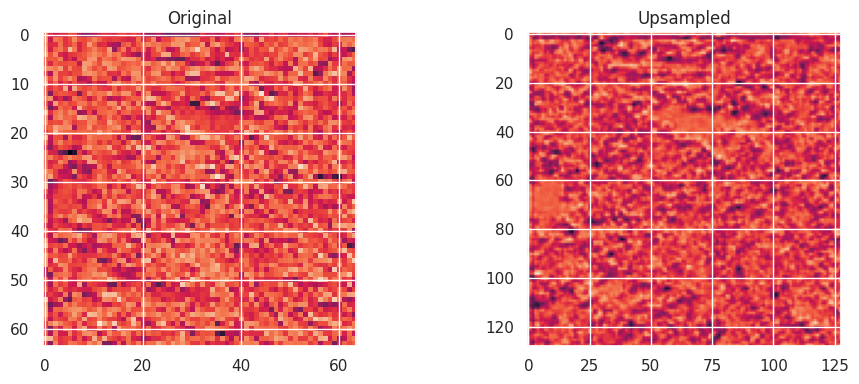

In [18]:
# Test Upsample
upsample = Upsample(in_channels=64, use_conv=True, out_channels=128).cuda()
x = encoded  # Example input
x = x.to('cuda')  # Move to GPU if needed
x_upsampled = upsample(x)
print("Original shape:", x.shape)
print("Upsampled shape:", x_upsampled.shape)
# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("Original")
# plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_upsampled[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("Upsampled")
# plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
upsample.visualize_network(x)

In [22]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define parameters for ResBlock
in_channels = 64  # To match your tensor size
out_channels = 64  # Keep same output channels
emb_channels = 256  # Typical embedding dimension
dropout = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lora_rank = 16

print(f"Using device: {device}")

# Create sample input tensor with size [1, 64, 64, 64]
x =encoded.to('cuda')
print(f"Input tensor shape: {x.shape}")

# Create sample timestep embedding
# Using a random timestep value between 0 and 1000
timestep = torch.tensor([500], device=device)
emb = timestep_embedding(timestep, emb_channels)
print(f"Embedding shape: {emb.shape}")

# Initialize ResBlock
resblock = ResBlock(
    emb_channels=emb_channels,
    dropout=dropout,
    in_channels=in_channels,
    out_channels=out_channels,
    use_scale_shift_norm=True,
    device=device,
    is_trainable=True,
    lora_rank=lora_rank
)
resblock.to(device)

# Forward pass
with torch.no_grad():
    output = resblock(x, emb)

print(f"Output tensor shape: {output.shape}")

# Check if output has the expected shape
assert output.shape == x.shape, f"Expected shape {x.shape} but got {output.shape}"

# Print some statistics about the output
print(f"Output mean: {output.mean().item()}")
print(f"Output std: {output.std().item()}")
print(f"Output min: {output.min().item()}")
print(f"Output max: {output.max().item()}")

print("ResBlock test completed successfully!")

Using device: cuda
Input tensor shape: torch.Size([1, 64, 64, 64])
Embedding shape: torch.Size([1, 256])
Output tensor shape: torch.Size([1, 64, 64, 64])
Output mean: 0.012706119567155838
Output std: 0.6695774793624878
Output min: -3.5075809955596924
Output max: 3.5781190395355225
ResBlock test completed successfully!


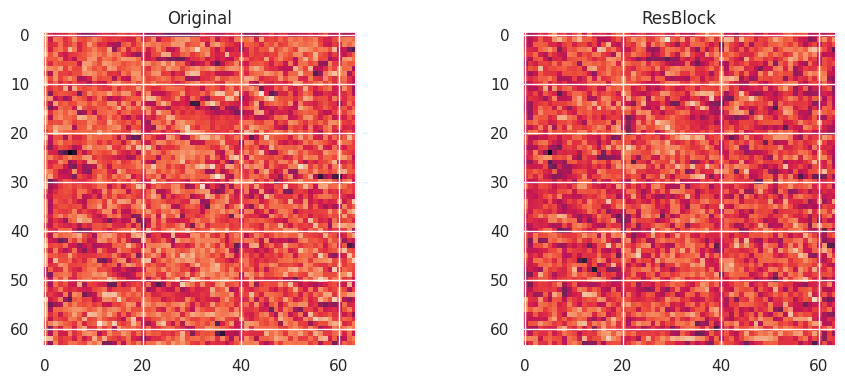

In [23]:
# Visualize output 
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("Original")
# plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output[0, 0].detach().cpu().numpy())  # Channel 0
plt.title("ResBlock")
# plt.axis('off')
plt.tight_layout()
plt.show()


---

## Test  Test cross attention

In [1]:
import torch
import torch.nn as nn
from xformers.ops import memory_efficient_attention

class FlashStyleCrossAttention(nn.Module):
    def __init__(self, z_dim=64, style_dim=512, heads=4):
        super().__init__()
        self.heads = heads
        self.head_dim = z_dim // heads
        
        # Ensure z_dim is divisible by heads
        assert z_dim % heads == 0, f"z_dim {z_dim} must be divisible by heads {heads}"
        
        self.to_q = nn.Linear(z_dim, z_dim, bias=False)
        self.to_k = nn.Linear(style_dim, z_dim, bias=False)
        self.to_v = nn.Linear(style_dim, z_dim, bias=False)
        self.out_proj = nn.Linear(z_dim, z_dim)
        
    def forward(self, z, style):
        B, C, H, W = z.shape
        _, N, D = style.shape
        
        z_flat = z.permute(0, 2, 3, 1).reshape(B, H * W, C)  # (B, HW, C)
        
        Q = self.to_q(z_flat)  # (B, HW, C)
        K = self.to_k(style)   # (B, N, C)
        V = self.to_v(style)   # (B, N, C)
        
        # xformers expects input tensors in the format [batch_size, seq_len, num_heads, head_dim]
        # Then it internally transforms them to [batch_size * num_heads, seq_len, head_dim]
        Q = Q.view(B, H * W, self.heads, self.head_dim).permute(0, 2, 1, 3)  # [B, heads, HW, head_dim]
        K = K.view(B, N, self.heads, self.head_dim).permute(0, 2, 1, 3)      # [B, heads, N, head_dim]
        V = V.view(B, N, self.heads, self.head_dim).permute(0, 2, 1, 3)      # [B, heads, N, head_dim]
        
        # Flatten batch and head dimensions for xformers
        Q = Q.reshape(B * self.heads, H * W, self.head_dim)
        K = K.reshape(B * self.heads, N, self.head_dim)
        V = V.reshape(B * self.heads, N, self.head_dim)
        
        # Call memory_efficient_attention
        attn_output = memory_efficient_attention(
            Q, K, V,
            attn_bias=None,  # No attention bias
            op=None,         # Let xformers choose the best operator
        )  # (B * heads, HW, head_dim)
        
        # Reshape back
        attn_output = attn_output.view(B, self.heads, H * W, self.head_dim)
        attn_output = attn_output.permute(0, 2, 1, 3).reshape(B, H * W, C)
        out = self.out_proj(attn_output)
        out = out.view(B, H, W, C).permute(0, 3, 1, 2)  # (B, C, H, W)
        
        return out

# === TEST ===
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    z = torch.randn(1, 64, 64, 64, device=device)       # (B, C, H, W)
    style = torch.randn(1, 18, 512, device=device)      # (B, N_tokens, D_embed)
    
    model = FlashStyleCrossAttention(z_dim=64, style_dim=512, heads=4).to(device)
    z_out = model(z, style)
    
    print(f"Input z shape:     {z.shape}")
    print(f"Style shape:       {style.shape}")
    print(f"Output z_out shape:{z_out.shape}")
    print(f"Computation device: {z_out.device}")

Input z shape:     torch.Size([1, 64, 64, 64])
Style shape:       torch.Size([1, 18, 512])
Output z_out shape:torch.Size([1, 64, 64, 64])
Computation device: cuda:0
